In [0]:
import csv
from gensim.models import Word2Vec
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, ThresholdedReLU, Flatten
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow import keras
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import seaborn as sns
import re
import math
import pickle
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import collections
import random
# tf.test.gpu_device_name() 

In [21]:
from google.colab import drive
drive.mount('/content/drive')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def getplot(coords):
  S = set(coords)
  F = {}
  for i in list(S):
    F[i] = coords.count(i)
  K = F.keys()
  Xs = [i[0] for i in K]
  Ys = [i[1] for i in K]
  plt.scatter(Xs,Ys)
  for i in K:
    plt.annotate(F[i], xy=i)
  plt.xlabel("Ground truth families 1-10")
  plt.ylabel("Clustering families")
  return plt

In [0]:
def getScore2(cluster, truth):
  # cluster and truth are dataframes
  clu_family = dict()
  for row in cluster.iterrows():
    cur_f = row[1].family
    cur_dn = row[1].domain
    if cur_f not in clu_family:
      clu_family[cur_f] = set()
    clu_family[cur_f].add(cur_dn)

  clu_domain = dict()
  for row in cluster.iterrows():
    cur_f = row[1].family
    cur_dn = row[1].domain
    clu_domain[cur_dn] = cur_f


  truth_family = dict()
  for row in truth.iterrows():
    cur_f = row[1].family
    cur_dn = row[1].domain
    if cur_f not in truth_family:
      truth_family[cur_f] = set()
    truth_family[cur_f].add(cur_dn)

  truth_domain = dict()
  for row in truth.iterrows():
    cur_f = row[1].family
    cur_dn = row[1].domain
    truth_domain[cur_dn] = cur_f

  # calculate the score
  N = len(truth)
  res = 0
  for row in cluster.iterrows():
    cur_dn = row[1].domain
    pre_family = clu_domain[cur_dn]
    pre_set = clu_family[pre_family]
    
    if cur_dn in truth_domain:
      gt_family = truth_domain[cur_dn]
      gt_set = truth_family[gt_family]
    else:
      gt_set = set()

    numerator = len(pre_set.intersection(gt_set))
    denominator = len(pre_set) + len(gt_set) - numerator

    res += numerator / denominator

  return res / N


In [0]:
df = pd.read_csv('/content/drive/Shared drives/Hackathon_new/q2_revised.csv', encoding='latin1')
gt = pd.read_excel('/content/drive/Shared drives/Hackathon_new/q2_answer.xlsx')
gt.drop_duplicates(subset=['domain'], keep='last', inplace=True)

In [0]:
y = list(gt['family'])

In [0]:
with open('/content/drive/Shared drives/Hackathon_new/DF_var.pkl', 'rb') as pickle_file:
    matrix = pickle.load(pickle_file)
matrix = matrix.loc[~matrix.index.duplicated(keep='first')]

with open('/content/drive/Shared drives/Hackathon_new/alexadataframe.pkl', 'rb') as pickle_file:
    features = pickle.load(pickle_file)

## Random Guess

0.06148572741102541


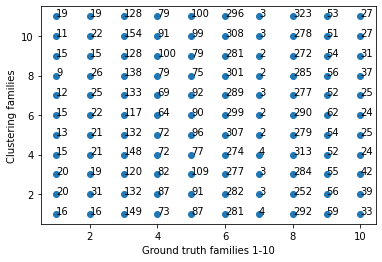

In [27]:
def randCluster(gt, num_family):
  f = []
  for _ in range(len(gt)):
    f.append(random.randint(1, num_family))
  
  cluster = pd.DataFrame(list(zip(list(gt.domain), f)), columns =['domain', 'family']) 

  return cluster

rand_cluster = randCluster(gt, 11)
print(getScore2(rand_cluster, gt))
getplot(tuple(zip(y,list(rand_cluster['family'])))).show()


### PCA relational matrix

In [0]:
matrix_np = matrix.to_numpy()
pca = PCA(n_components=10)
pca_matrix = pca.fit_transform(matrix_np)

#results from purely looking at which IPs are querying family infected sites

In [29]:
clustering = DBSCAN(eps=0.6, min_samples=50).fit(pca_matrix)
collections.Counter(clustering.labels_)

Counter({-1: 2,
         0: 5460,
         1: 681,
         2: 2074,
         3: 93,
         4: 196,
         5: 227,
         6: 258,
         7: 261,
         8: 625,
         9: 183,
         10: 273,
         11: 287,
         12: 59,
         13: 204,
         14: 169})

0.10728135302325979


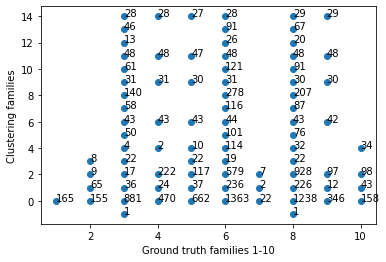

In [30]:
cluster = pd.DataFrame(list(zip(list(matrix.index), clustering.labels_)), columns =['domain', 'family']) 
print(getScore2(cluster, gt))
getplot(tuple(zip(y,list(clustering.labels_)))).show() #this is soley based on IP addresses querying domains. we see a slight improvement from completely random

## Concatate other features

In [0]:
cols = ['gaf'+str(i) for i in range(len(pca_matrix[0]))]
dfp2 = pd.DataFrame(data=pca_matrix, columns=cols)
dfp2['dns'] = matrix.index
dfp2 = pd.merge(dfp2, features, how='inner', on=['dns'])
dfp2['tld'] = dfp2.dns.apply(lambda x: x.split('.')[-1])
for tld in dfp2.tld.unique():
  dfp2[tld] = dfp2.tld.apply(lambda x: 1 if x==tld else 0)

In [0]:
part1_model = keras.models.load_model('/content/drive/Shared drives/Hackathon_new/mit.model')

In [0]:
def dnsToMatrix(dns):
    maxl = 63
    asc = [ord(i.lower()) for i in dns]
    if len(asc) > 63: # if domain name is longer than 63, just use the last 63
        asc = asc[-63:]
    else:
        asc = [0] * (maxl-len(asc)) + asc
    asc = np.array(asc)
    
    return asc

np_x = []
for dns in dfp2.dns:
    np_x.append(dnsToMatrix(dns))
np_x = np.stack(np_x, axis=0)
predict = part1_model.predict(np_x)
dfp2['score1'] = predict

In [34]:
dfp2.head()

,gaf0,gaf1,gaf2,gaf3,gaf4,gaf5,gaf6,gaf7,gaf8,gaf9,dns,family,MCR,1gramscore,2gramscore,entropy1gram,entropy2grams,dnsLength,tld,so,in,tk,ws,to,biz,ru,info,net,co,org,online,uk,cc,score1
0,-0.239509,-0.086493,-0.011,-0.001005,-0.017119,-0.012184,-0.091107,0.001488,0.010766,-0.020686,z54f71fcb61e49158f3648236556b04eb1.so,1,0.0,0.011614,0.000153,4.583877,9.494573,37,so,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.989197
1,-0.239509,-0.086493,-0.011,-0.001005,-0.017119,-0.012184,-0.091107,0.001488,0.010766,-0.020686,l31f5dcf7f398d2b94cd9155ee392c701b.so,1,0.0,0.017069,0.000175,3.848717,9.438155,37,so,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.986357
2,-0.239509,-0.086493,-0.011,-0.001005,-0.017119,-0.012184,-0.091107,0.001488,0.010766,-0.020686,d442a48406424819e686a5d1fde7c602ea.so,1,0.0,0.022486,0.000436,4.167521,9.332163,37,so,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.989674
3,-0.239509,-0.086493,-0.011,-0.001005,-0.017119,-0.012184,-0.091107,0.001488,0.010766,-0.020686,zba909e91846ce27aff7902f9228ee40ea.so,1,0.0,0.027097,0.000621,3.849810,8.768205,37,so,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.989570
4,-0.239509,-0.086493,-0.011,-0.001005,-0.017119,-0.012184,-0.091107,0.001488,0.010766,-0.020686,p8f5889e854374cf8e70e91f456807f83f.so,1,0.0,0.013928,0.000038,4.890775,10.218740,37,so,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.983259


#Using soley string features without TLDs

In [44]:
# get features
colName = list(dfp2.columns)

remove = ['dns', 'family', 'tld', 'so', 'in', 'tk', 'ws', 'to', 'biz', 'ru', 'info', 'net', 'co', 'org', 'online', 'uk', 'cc']

# remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1']

#remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1', '2gramscore', '1gramscore', 'MCR', 'dnsLength']
cols = ['gaf'+str(i) for i in range(len(pca_matrix[0]))]
for f in cols:
  remove.append(f)

# for tld in dfp2.tld.unique():
#   remove.append(tld)

for col in remove:
  colName.remove(col)
train_data = dfp2[colName].to_numpy()
print('The number of features: {}.'.format(train_data.shape[1]))

The number of features: 7.


In [45]:
clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='euclidean').fit(train_data)
# clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='manhattan').fit(train_data)
collections.Counter(clustering.labels_)

Counter({-1: 111, 0: 207, 1: 7482, 2: 3252})

0.1829425447748183


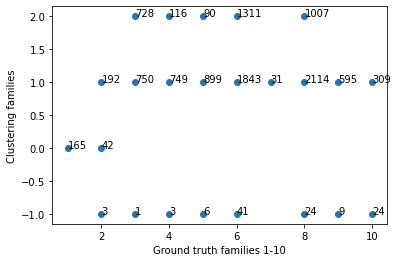

In [46]:
cluster = pd.DataFrame(list(zip(list(matrix.index), clustering.labels_)), columns =['domain', 'family']) 
print(getScore2(cluster, gt))
getplot(tuple(zip(y,list(clustering.labels_)))).show()

#Using String features and IP without TLDs

In [47]:
# get features
colName = list(dfp2.columns)

remove = ['dns', 'family', 'tld', 'so', 'in', 'tk', 'ws', 'to', 'biz', 'ru', 'info', 'net', 'co', 'org', 'online', 'uk', 'cc']

# remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1']

#remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1', '2gramscore', '1gramscore', 'MCR', 'dnsLength']
# cols = ['gaf'+str(i) for i in range(len(pca_matrix[0]))]
# for f in cols:
#   remove.append(f)

# for tld in dfp2.tld.unique():
#   remove.append(tld)

for col in remove:
  colName.remove(col)
train_data = dfp2[colName].to_numpy()
print('The number of features: {}.'.format(train_data.shape[1]))

The number of features: 17.


In [48]:
clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='euclidean').fit(train_data)
# clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='manhattan').fit(train_data)
collections.Counter(clustering.labels_)

Counter({-1: 293, 0: 207, 1: 7332, 2: 3220})

0.18158794636754097


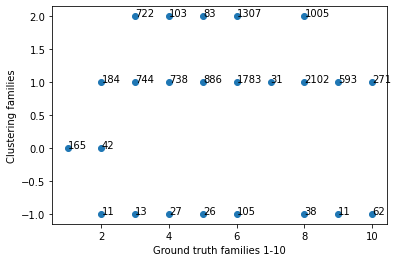

In [49]:
cluster = pd.DataFrame(list(zip(list(matrix.index), clustering.labels_)), columns =['domain', 'family']) 
print(getScore2(cluster, gt))
getplot(tuple(zip(y,list(clustering.labels_)))).show()

#Using all features

In [90]:
# get features
colName = list(dfp2.columns)

remove = ['dns', 'family', 'tld']

#remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1']

#remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1', '2gramscore', '1gramscore', 'MCR', 'dnsLength']
#remove = ['dns', 'family', 'tld', 'entropy2grams', '2gramscore', 'so', 'in', 'tk', 'ws', 'to', 'biz', 'ru', 'info', 'net', 'co', 'org', 'online', 'uk', 'cc']

# cols = ['gaf'+str(i) for i in range(len(pca_matrix[0]))]
# for f in cols:
#   remove.append(f)

#for tld in dfp2.tld.unique():
#  remove.append(tld)

for col in remove:
  colName.remove(col)
train_data = dfp2[colName].to_numpy()
print('The number of features: {}.'.format(train_data.shape[1]))

The number of features: 31.


In [91]:
clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='euclidean').fit(train_data)
# clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='manhattan').fit(train_data)
collections.Counter(clustering.labels_)

Counter({-1: 2533,
         0: 578,
         1: 626,
         2: 155,
         3: 449,
         4: 594,
         5: 1418,
         6: 92,
         7: 1239,
         8: 1991,
         9: 936,
         10: 441})

0.3894946797540776


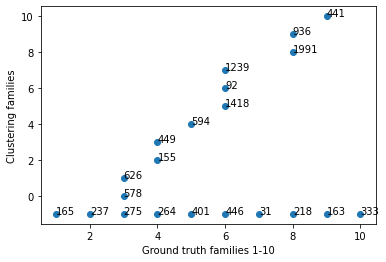

In [92]:
cluster = pd.DataFrame(list(zip(list(matrix.index), clustering.labels_)), columns =['domain', 'family']) 
print(getScore2(cluster, gt))
getplot(tuple(zip(y,list(clustering.labels_)))).show()

#Using all features besides IP

In [75]:
# get features
colName = list(dfp2.columns)

remove = ['dns', 'family', 'tld']

#remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1']

#remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1', '2gramscore', '1gramscore', 'MCR', 'dnsLength']
#remove = ['dns', 'family', 'tld', 'entropy2grams', '2gramscore', 'so', 'in', 'tk', 'ws', 'to', 'biz', 'ru', 'info', 'net', 'co', 'org', 'online', 'uk', 'cc']

cols = ['gaf'+str(i) for i in range(len(pca_matrix[0]))]
for f in cols:
  remove.append(f)

#for tld in dfp2.tld.unique():
#  remove.append(tld)

for col in remove:
  colName.remove(col)
train_data = dfp2[colName].to_numpy()
print('The number of features: {}.'.format(train_data.shape[1]))

The number of features: 21.


In [76]:
clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='euclidean').fit(train_data)
# clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='manhattan').fit(train_data)
collections.Counter(clustering.labels_)

Counter({-1: 1546,
         0: 98,
         1: 664,
         2: 706,
         3: 172,
         4: 488,
         5: 718,
         6: 1775,
         7: 1293,
         8: 2063,
         9: 990,
         10: 462,
         11: 77})

0.4696363786212817


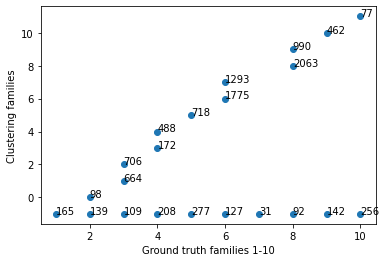

In [77]:
cluster = pd.DataFrame(list(zip(list(matrix.index), clustering.labels_)), columns =['domain', 'family']) 
print(getScore2(cluster, gt))
getplot(tuple(zip(y,list(clustering.labels_)))).show()

#Using only 1 gram score, MCR, length, and TLDs

In [84]:
# get features
colName = list(dfp2.columns)

#remove = ['dns', 'family', 'tld']

remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams','2gramscore', 'score1']

#remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1', '2gramscore', '1gramscore', 'MCR', 'dnsLength']

cols = ['gaf'+str(i) for i in range(len(pca_matrix[0]))]
for f in cols:
  remove.append(f)

#for tld in dfp2.tld.unique():
#  remove.append(tld)

for col in remove:
  colName.remove(col)
train_data = dfp2[colName].to_numpy()
print('The number of features: {}.'.format(train_data.shape[1]))

The number of features: 17.


In [85]:
clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='euclidean').fit(train_data)
# clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='manhattan').fit(train_data)
collections.Counter(clustering.labels_)

Counter({-1: 566,
         0: 185,
         1: 726,
         2: 722,
         3: 745,
         4: 892,
         5: 1861,
         6: 1313,
         7: 2114,
         8: 1029,
         9: 70,
         10: 499,
         11: 330})

0.587276722286416


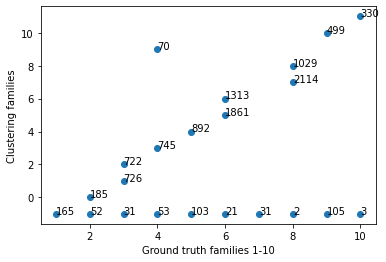

In [86]:
cluster = pd.DataFrame(list(zip(list(matrix.index), clustering.labels_)), columns =['domain', 'family']) 
print(getScore2(cluster, gt))
getplot(tuple(zip(y,list(clustering.labels_)))).show()

## Using only TLDs





In [81]:
#Using only TLDs gives the highest score
# get features
colName = list(dfp2.columns)

# remove = ['dns', 'family', 'tld']

# remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1']

remove = ['dns', 'family', 'tld', 'entropy1gram', 'entropy2grams', 'score1', '2gramscore', '1gramscore', 'MCR', 'dnsLength']
cols = ['gaf'+str(i) for i in range(len(pca_matrix[0]))]
for f in cols:
  remove.append(f)

# for tld in dfp2.tld.unique():
#   remove.append(tld)

for col in remove:
  colName.remove(col)
print(list(colName))
train_data = dfp2[colName].to_numpy()
print('The number of features: {}.'.format(train_data.shape[1]))

['so', 'in', 'tk', 'ws', 'to', 'biz', 'ru', 'info', 'net', 'co', 'org', 'online', 'uk', 'cc']
The number of features: 14.


In [82]:
clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='euclidean').fit(train_data)
# clustering = DBSCAN(eps=1.4, min_samples=50, algorithm='auto', metric='manhattan').fit(train_data)
collections.Counter(clustering.labels_)

Counter({-1: 224,
         0: 237,
         1: 1479,
         2: 868,
         3: 995,
         4: 3195,
         5: 3145,
         6: 551,
         7: 358})

0.9823587306760875


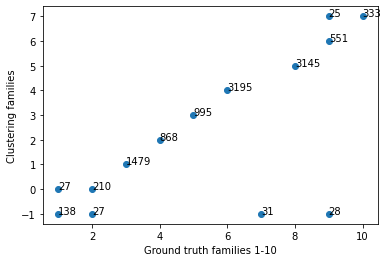

In [83]:
cluster = pd.DataFrame(list(zip(list(matrix.index), clustering.labels_)), columns =['domain', 'family']) 
print(getScore2(cluster, gt))
getplot(tuple(zip(y,list(clustering.labels_)))).show()

### Random Guess: 0.0616

### Group Activities: 0.1073

### DGA string characteristics without TLD: 0.1829

### Group Activities and DGA string characteristics without TLD 0.1816

### All Features: 0.3895

### All features without IP: 0.4696

### Using only 1 gram score, MCR, length, and TLDs: 0.5873

### Only TLD (Top Level Domain): <font color='red'>0.9824</font>

In [38]:
gt.groupby('family').count()

,domain
family,
1,165
2,237
3,1479
4,868
5,995
6,3195
7,31
8,3145
9,604
